In [1]:
import librosa
import librosa.feature
import numpy as np
import matplotlib.pyplot as plt

### Find F0 using Autocorrelation

In [2]:
def autocorrelation(signal):
    result = np.correlate(signal, signal, mode='full')
    mid = len(result) // 2
    return result[mid:]

def find_f0(signal, sr, min_freq=50, max_freq=500):
    ac = autocorrelation(signal)
    # Xác định chỉ số của độ trễ (delay) tương ứng với tần số cơ bản
    ac = ac[int(sr / max_freq):]
    # Tìm chỉ số của độ trễ tối đa
    peak = np.argmax(ac)
    # Tính F0 từ chỉ số độ trễ
    f0 = sr / (peak + int(sr / max_freq))
    
    # Nếu F0 nằm ngoài khoảng cho phép, trả về NaN
    if f0 < min_freq or f0 > max_freq:
        return np.nan
    
    return f0

### Find energy of audio

In [3]:
def define_energy(x: np.ndarray, frame_length, hop_length) -> np.ndarray:
    energy = np.array([
        sum(abs(x[i:i+frame_length]**2))
        for i in range(0, len(x), hop_length)
    ])

    return energy

### Tìm những frame có âm thanh

In [4]:
def find_voice_index(audio: np.ndarray, frame_length, hop_length, thresh=0.1) -> list:
    index_voices = []

    # Tính energy
    energy = define_energy(audio, frame_length, hop_length)

    energy_norm = energy / max(energy)

    # Tạo danh sách các frame index mà energy >= ngưỡng
    for i in range(len(energy)):
        if energy_norm[i] >= thresh:
            index_voices.append(i)

    return index_voices

### Xác định F0

In [5]:
def find_f0s(audio: np.ndarray, index_voices: list, frame_length: int, hop_length: int, sr: int) -> np.ndarray:
    f0s = np.zeros(len(audio))

    for i in index_voices:
        start_sample_index = librosa.frames_to_samples(i, hop_length=hop_length)
        end_sample_index = start_sample_index + frame_length
        f0 = find_f0(audio[start_sample_index:end_sample_index], sr)
        f0s[start_sample_index:end_sample_index] = f0

    return f0s

In [6]:
def split_segments(index_voices: list) -> list:
    start = index_voices[0]
    segments = []
    for i in range(1, len(index_voices)):
        if index_voices[i] - index_voices[i-1] > 1:
            segments.append((start, index_voices[i-1]))
            start = index_voices[i]
    segments.append((start, index_voices[-1]))
    return segments

In [7]:
def analize_audio(file_path: str, frame_length_ms, thresh=0.1) -> None:
    audio, sr = librosa.load(file_path, sr=None)
    frame_length = int(frame_length_ms * sr / 1000)
    hop_length = frame_length // 2
    print(f'Frame length: {frame_length}, Hop length: {hop_length}')

    # Find energy
    energy = define_energy(audio, frame_length, hop_length)
    energy_norm = energy / max(energy)
    
    t = librosa.frames_to_time(range(len(energy)), sr=sr, hop_length=hop_length)

    index_voices = find_voice_index(audio, frame_length, hop_length, thresh)

    # Find f0
    f0s = find_f0s(audio, index_voices, frame_length, hop_length, sr)

    segments = split_segments(index_voices)

    # Plot waveform
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(t, energy_norm)
    plt.xlabel('Time (s)')
    plt.ylabel('Energy')

    plt.subplot(3, 1, 2)
    plt.plot(f0s)
    plt.xlabel('Sample index')
    plt.ylabel('F0')

    plt.subplot(3, 1, 3)
    plt.plot(audio)
    # Đánh dấu tần số cơ bản (F0) trên đồ thị phổ tần số
    for i in segments:
        # define start and end of the segment
        start_sample_index = librosa.frames_to_samples(i[0], hop_length=hop_length)
        end_sample_index = librosa.frames_to_samples(i[1], hop_length=hop_length) + frame_length

        plt.axvline(start_sample_index, color='r')
        # fill the segment with green color
        plt.axvspan(start_sample_index, end_sample_index, color='g', alpha=0.5)
        plt.axvline(end_sample_index, color='r')
        
    plt.xlabel('Sample index')
    plt.ylabel('Amplitude')
    plt.show()

Frame length: 240, Hop length: 120


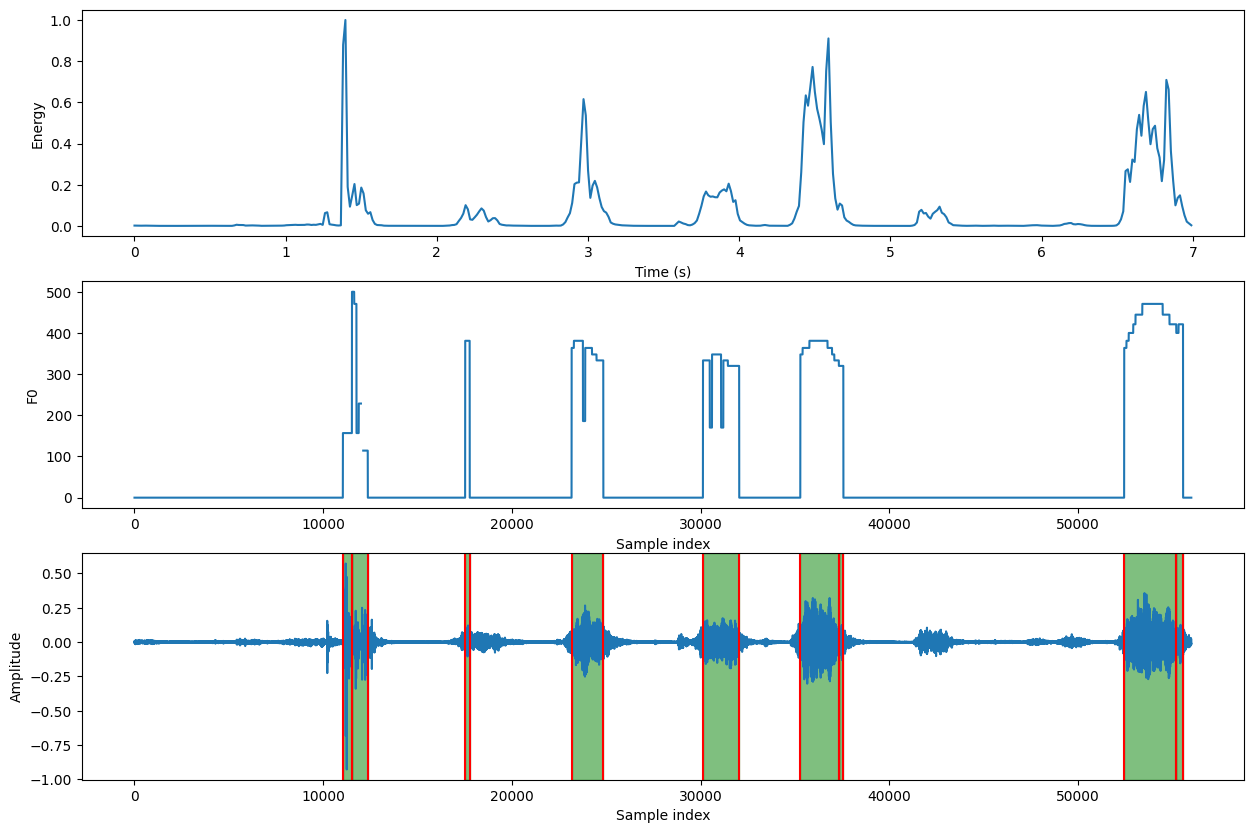

In [8]:
analize_audio('data/1_belly_pain.wav', 30, 0.1)

Frame length: 240, Hop length: 120


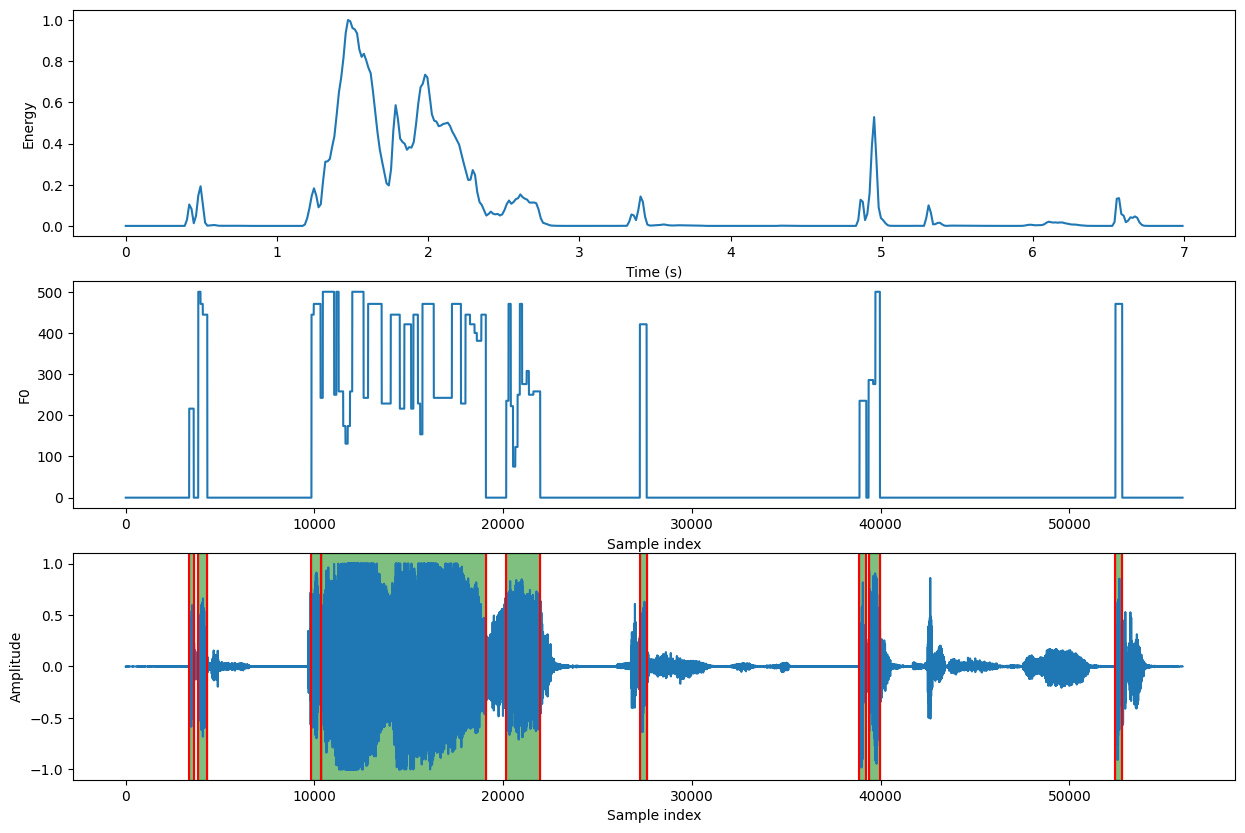

In [9]:
analize_audio('data/2_burping.wav', 30, 0.1)

Frame length: 240, Hop length: 120


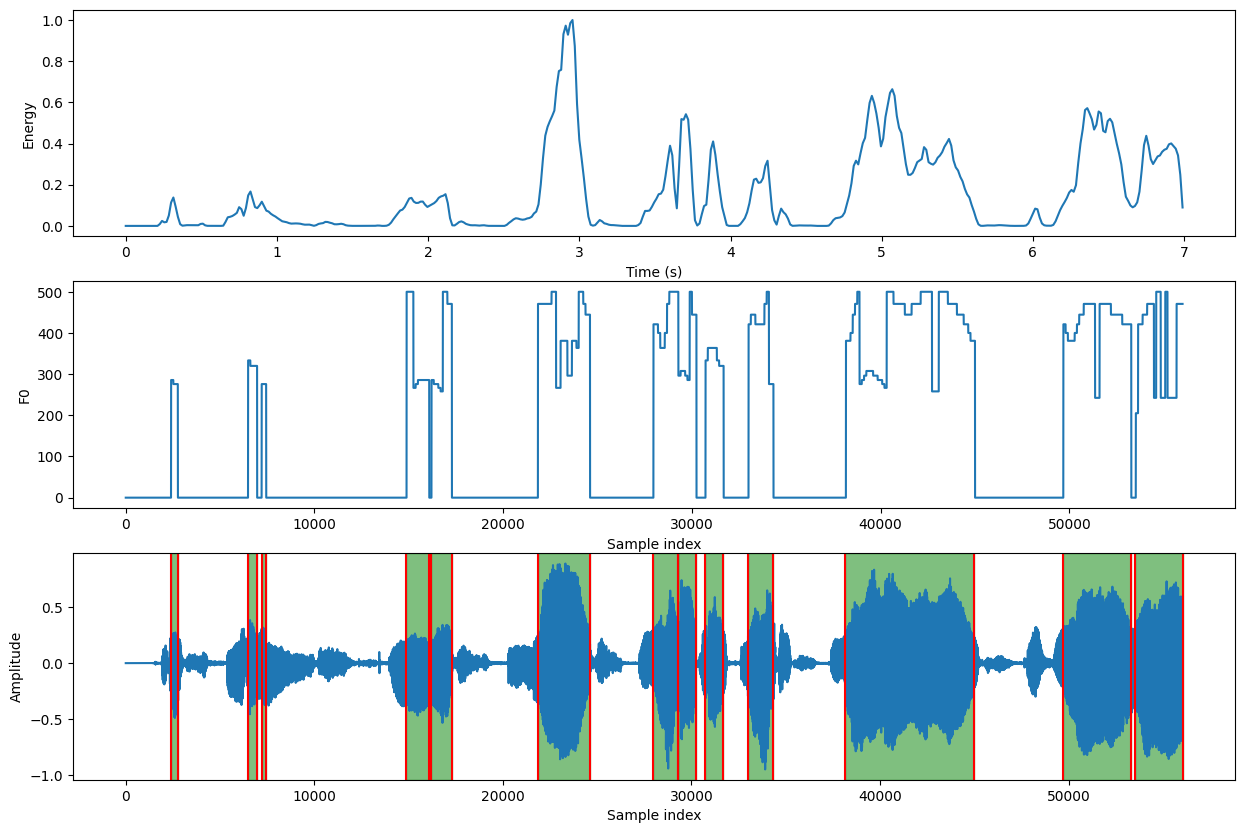

In [10]:
analize_audio('data/3_discomfort.wav', 30, 0.1)

Frame length: 240, Hop length: 120


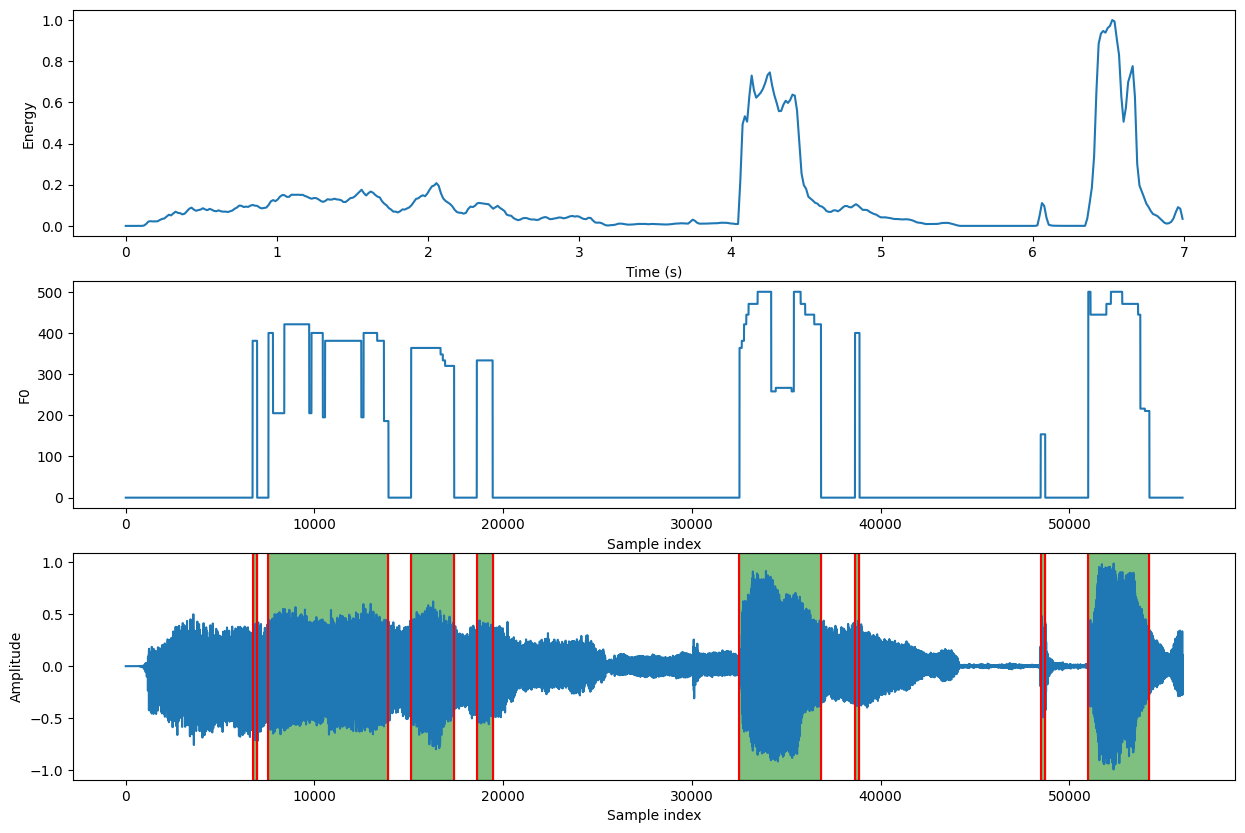

In [11]:
analize_audio('data/4_hungry.wav', 30, 0.1)

Frame length: 240, Hop length: 120


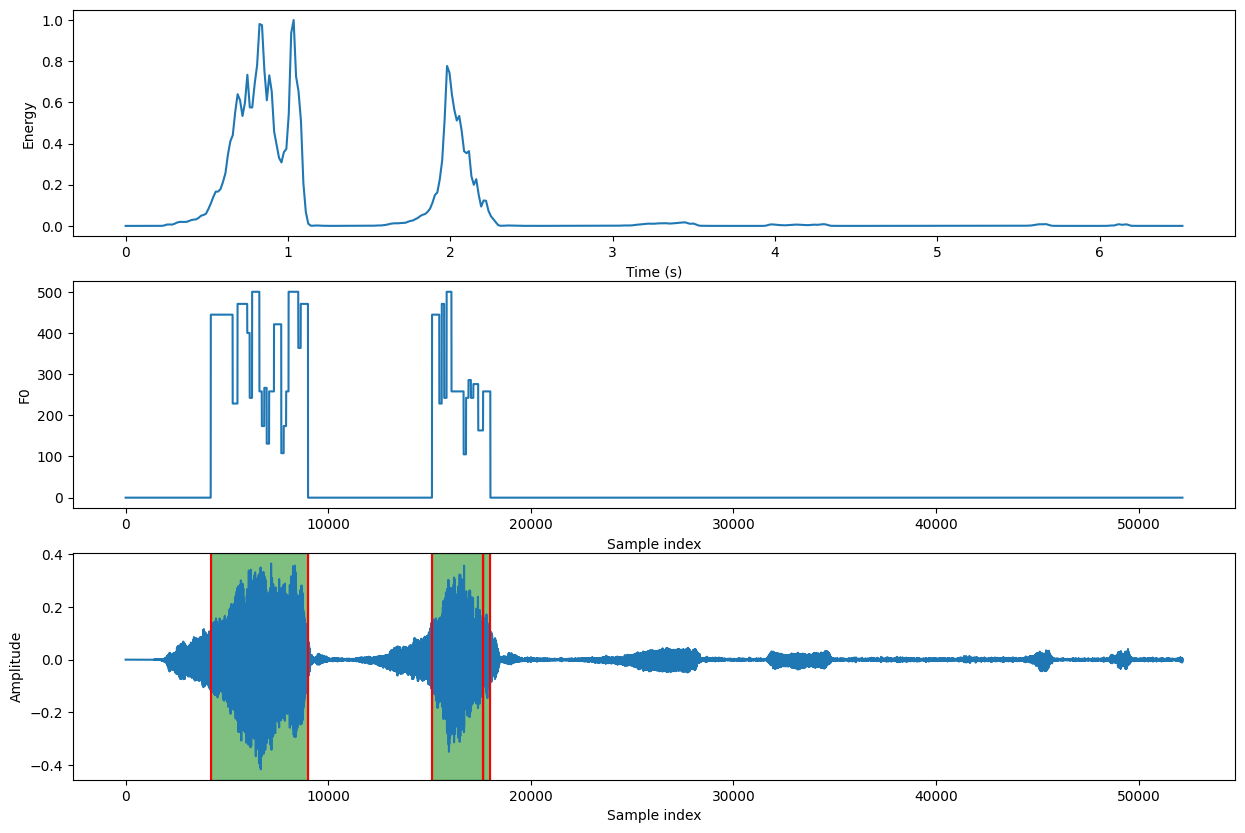

In [12]:
analize_audio('data/5_tired.wav', 30, 0.1)